# Machine learning needs data

Without data, machine learning is nothing. After all what will it learn if it has nothing to learn from. Think about everything you've learned throughout your life. All the books you've read, the movies you've watched, the experiences you've lived. Everything you've touched, tasted, heard, felt, smelled. It all comes together to shape who you are and what you know. Our brains adapt and change to all of this input. Our brains _learn_. Take away all of the memories and experiences and what are we left with? Thoughts maybe, but of what? Without the context of our life there isn't much to think about. Machine learning models work kind of like our brain, but much simpler. They take data and try to make sense of it, or _learn_ from it. The more data, the easier it is to learn from, at least in theory.

While we will dive into many algorithms over the course of this book, I want to drive home that machine learning models _need_ data to learn. We can have the fanciest neural network on the best GPU cluster in the world, but without data, it's all pointless. To drive this point home let's see some machine learning in action.

We'll start with a line. Nothing special, just the equation `y = x`.

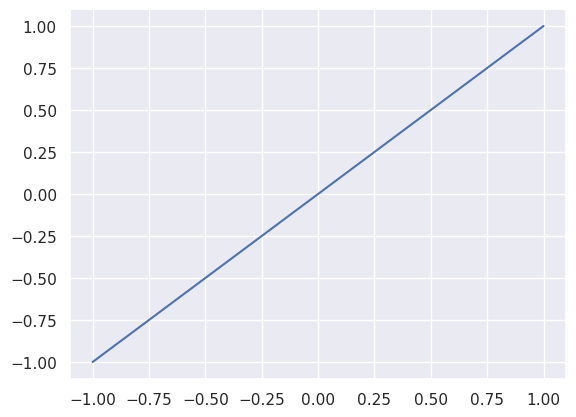

In [1]:
import seaborn as sns
sns.set_theme(style='darkgrid')

x = y = [-1, 1]
_ = sns.lineplot(x=x, y=y)

[I love [`seaborn`](https://seaborn.pydata.org/) for rapid data visualization. It can't do everything perfectly, but it does the common things beautifully.]{.aside}This line is the ground truth. It is real. But let's imagine we don't have the line. We just have a couple random points on the line.

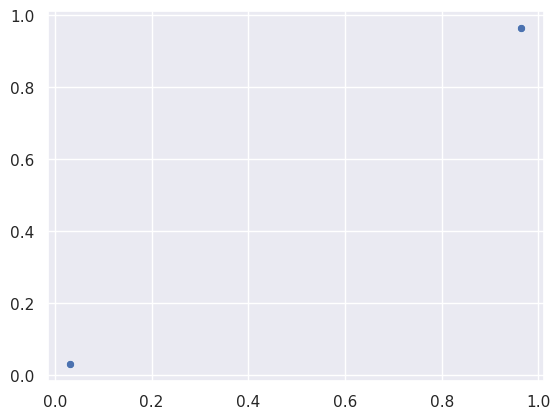

In [2]:
import random
import pandas as pd

random.seed(100392)

def random_x(n):
    """Return `n` random values from -1 to 1."""
    return [random.uniform(-1, 1) for _ in range(n)]

xs = ys = random_x(2)
_ = sns.scatterplot(x=xs, y=ys)

Visually, we could draw a line from dot to dot and we'd get the same line in the previous plot. But we're not interested in figuring out the line ourselves. We're here to have machine learning do it for us. This is already integrated into `seaborn` so there's not much code for us to write. The [`regplot`](https://seaborn.pydata.org/generated/seaborn.regplot.html) function will plot our data points and use machine learning to fit a line to those data points.

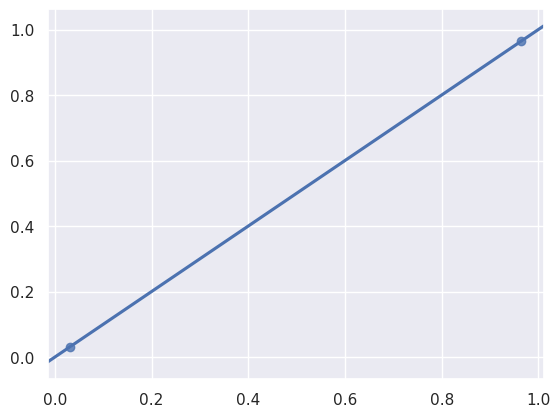

In [3]:
_ = sns.regplot(x=xs, y=ys, truncate=False, ci=False)

Will you look at that! The line was perfectly predicted based on the data points.

But real world data isn't this simple or this _clean_. There's usually some amount of noise[Noise is randomness introduced to the data. It can come from many places like imprecise measurements, mislabelling, or unaccounted variables to name a few.]{.aside} in the data that can affect the quality of predictions.

Now let's imagine we don't have points on the line, but points close to the line. How will this change the predicted line?

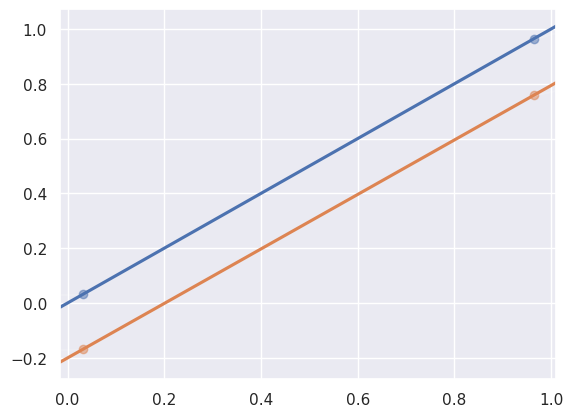

In [4]:
# Add noise to the data points to simulate noisy data.
def noisy_process(xs, noise):
    """Return noisy values of `xs`."""
    return [x + random.uniform(-noise, noise) for x in xs]

ys_noisy = noisy_process(xs, .25)

ax = sns.regplot(x=xs, y=ys, truncate=False, ci=False, scatter_kws={'alpha': 0.5})
_ = sns.regplot(x=xs, y=ys_noisy, truncate=False, ci=False, ax=ax, scatter_kws={'alpha': 0.5})

Hmm, that doesn't look so bad. The predicted line in orange is pretty close to the real line in blue and has the same slope. But what if we just got lucky and the random noise happened to be low? Maybe we should run it a few more times to be sure.[`pandas` is another great library we'll use over and over again. We'll get to more on that later.]{.aside}

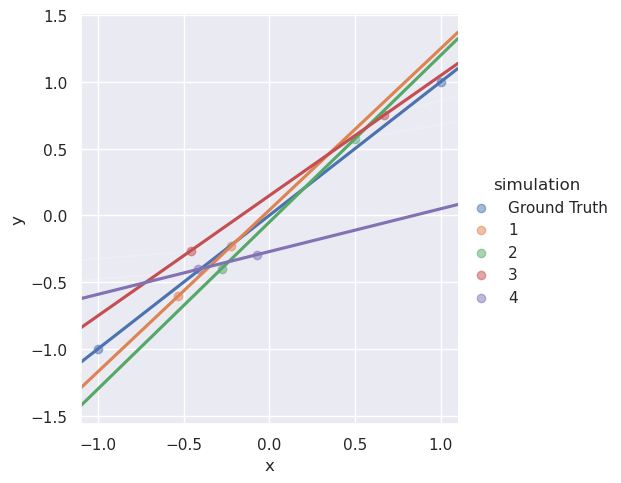

In [5]:
import pandas as pd

def simulate_n(n, n_points, noise):
    """Return a `pd.DataFrame` with `n` separate simulations of `n_points`."""
    data = []
    for x in [-1, 1]:
        data.append({'x': x, 'y': x, 'simulation': 'Ground Truth', 'noise': noise})
    for i in range(n):
        xs = random_x(n_points)
        ys = noisy_process(xs, noise)
        for x, y in zip(xs, ys):
            data.append(
                {'x': x, 'y':y, 'simulation': i+1, 'noise':noise}
            )
    return pd.DataFrame(data)

df = simulate_n(4, 2, 0.25)
# `lmplot` is a fancier version of `regplot` that can handle multiple
# lines.
_ = sns.lmplot(df, x="x", y='y', ci=False, hue='simulation', truncate=False, scatter_kws={'alpha': 0.5})

Most of these look pretty close to the blue line, the ground truth, but what's going on with simulation 4? The noise confused the machine learning model. It only has two points to work with and given two points it can figure out a line that perfectly lies on those two points. These two points imperfectly represent the real line and so the machine learned the line of this imperfect representation. And it gets worse with more noise.

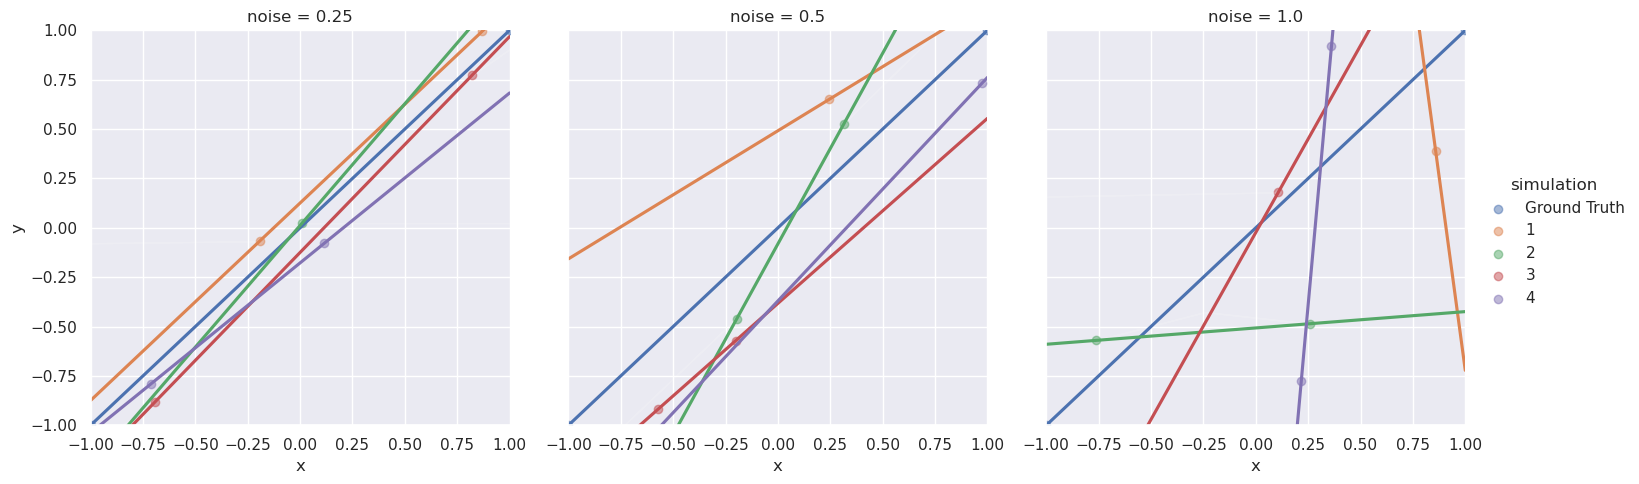

In [6]:
df = pd.concat([simulate_n(4, 2, noise) for noise in [0.25, 0.5, 1]])
_ = sns.lmplot(df, x='x',y='y', ci=False, hue='simulation', truncate=False, col='noise', scatter_kws={'alpha': 0.5},facet_kws={'xlim':(-1, 1), 'ylim':(-1, 1)})

Yup, that's a mess. But there is a way to learn from noisy data, you just need more of it. Let's try a hundred points per simulation.

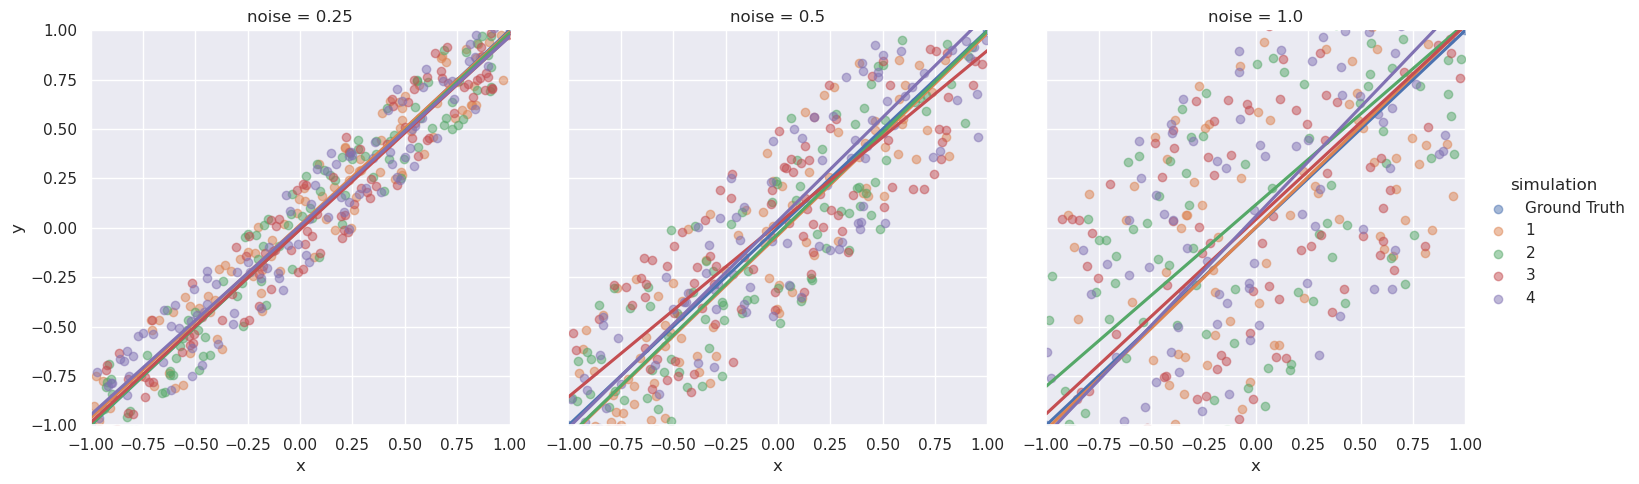

In [7]:
df = pd.concat([simulate_n(4, 100, noise) for noise in [0.25, 0.5, 1]])
_ = sns.lmplot(df, x='x',y='y', ci=False, hue='simulation', truncate=False, col='noise', scatter_kws={'alpha': 0.5},facet_kws={'xlim':(-1, 1), 'ylim':(-1, 1)})

That's night and day compared to two data points. Even when `noise = 1.0` the machine learning model does a good job of finding the line. This is because there's more information to learn from and the machine learning model can separate the noise and zero in on the truth.

The lesson here is data quality is important, but so is data _quantity_. Sometimes the answer is a better machine learning model, but that's not always true, you might just need more data.

# Getting the data

Our models will be using a dataset of movie reviews from IMDB [@maas-EtAl:2011:ACL-HLT2011]. There are several ways to get your hands on a dataset, you can curate them yourself or rely on the work of others. This dataset can be found at [https://ai.stanford.edu/~amaas/data/sentiment](https://ai.stanford.edu/~amaas/data/sentiment), but for simplicities sake it's included in the directory for this chapter.

Let's grab the data!

In [8]:
import pathlib
import tarfile

with tarfile.open('aclImdb_v1.tar.gz') as tar:
    tar.extractall(filter='data')
    data_path = pathlib.Path('aclImdb')
    # The untarred directory is `aclImdb` instead of `aclImdb_v1`.

This extracts the data from the tarball then assigns the output directory as a `pathlib.Path` object to `data_path`.[I highly recommend checking out the [pathlib](https://docs.python.org/3/library/pathlib.html) library if you don't already use it. It provides a nice object oriented API for handling file paths.]{.aside}

There are a lot of datasets out there. Some better than others. Before trying to predict anything, it's a good idea to get a sense of what the dataset actually contains. Hopefully the datasets you're using are well documented. The dataset we're working with comes with a README which we can see in the directory contents.[Don't worry if the paths shown in this notebook are different from the ones you see on your compute resource. The structure of the data directory should be the same, and by leveraging relative paths with `Path` objects, everything should just work.]{.aside}

In [9]:
list(data_path.iterdir())

[PosixPath('aclImdb/.ipynb_checkpoints'),
 PosixPath('aclImdb/imdbEr.txt'),
 PosixPath('aclImdb/README'),
 PosixPath('aclImdb/train'),
 PosixPath('aclImdb/imdb.vocab'),
 PosixPath('aclImdb/test')]

If you're working through this notebook in jupyter, I recommend taking a pause and reading the README yourself.

I'll summarize the main takeaways here for those of you reading this online.

## Overview

This dataset contains movie reviews and labels indicating if the review is positive (label 1) or negative (label 0). It is intended for benchmarking sentiment classification tasks. Sentiment classification is about predicting the feeling a text conveys. Like emotions such as happy, sad, or angry. In this case it's predicting whether a review says if a movie is good or bad.

## Dataset specifics

There are 50k reviews, split into two groups of 25k. One group is for training machine learning models and the other is for testing them. Within each group of 25k, the reviews are split into half positive and half negative.

There's at most 30 reviews for a given movie. The train and test sets have reviews for different movies, so none of the movies reviewed in the train set show up in the test set. Negative reviews have a score of 4 or less and positive reviews have a score of 7 or more.

There are an additional 50k reviews without any labels. These reviews are intended for unsupervised learning purposes (we'll learn about unsupervised learning in the future). There is an equal number of reviews with a score of 4 or less and 5 or more.

## Directory structure

The classification dataset file naming convention is `[DATASET]/[LABEL]/[ID]_[RATING].txt` where `DATASET` is one of `train` or `test`, `LABEL` is one of `pos` or `neg` (for positive and negative respectively), `ID` is a numeric identifier for a review, and `RATING` is the score the reviewer gave the movie.[A word of warning for jupyter lab users. Jupyter crashed when I tried to open the directories containing the reviews (like `train/pos`). My guess is there's too many files for jupyter to display and it becomes unresponsive. Your mileage may vary.]{.aside}

The unsupervised dataset file naming convention is `train/unsup/[ID]_0.txt` where `ID` is a numeric identifier for a review.

URLs to the reviews section are also provided in `[DATASET]/urls_[LABEL].txt`. The line `N` refers to `ID` `N` in the associated dataset/label combination. For example line 200 in `train/urls_pos.txt` refers to the review section for the movie of `train/pos/200_10.txt`. Here's an example URL from one of these files: http://www.imdb.com/title/tt0064354/usercomments. It turns out IMDB has changed their URL format so this link is broken. They now use "reviews" in place of "usercomments" like http://www.imdb.com/title/tt0064354/reviews. It is possible to mine additional information about these movies using these URLs, but APIs change and trying to gather that information programmatically over the web could break in the future so this book will focus on just the reviews.

# Question the dataset

An integral part of building a machine learning model is understanding where the data comes from and how it was acquired. There may be assumptions made during the data curation process that you don't agree with. An artefact in the data may have unintended side effects downstream, such as training a model that works very well on data it's seen but performs poorly on data it hasn't.

As you read about the dataset and it's curation process, I recommend you keep asking "why?" to better understand the choices made during the curation process. Why did they use those specific thresholds for choosing positive vs negative labels? Why that ratio of positive/negative labels? Why that many reviews per movie? Why set up the train/test sets that way?

In parallel, also think about _how_ you are going to leverage this data. Your end goal may be different from the curators of the dataset and that should be taken into account as you prepare the data for training machine learning models.

Here's a couple questions that come to my mind.

- Why isn't there a dataset for multi-label classification?
- Why a maximum of 30 reviews per movie? Why not 10 or 50?
- What was the rationale for picking the movies? Was it random or spread evenly by genre?
- Were the movies made during a certain time period?

Some of these questions we could answer ourselves if we want to and they can lead to a richer set of information. [IMDB provides an API](https://developer.imdb.com/) to programmatically gather movie data over the web. With that tool one can gather movie genres, release dates, associated actors, and more. If we never ask the questions we'll never think to look. Maybe we curate our own dataset because this one doesn't provide what we need or it leads to further analysis of the data and the dataset is tweaked based on that analysis.

## Cleaning the data

The data is spread out across multiple files, we just need to gather it together in a nice package. That nice package will be a [`pandas`](https://pandas.pydata.org/) dataframe. Dataframes are tables. `pandas` provides a ton of functionality to manipulate tables and learn about their content. You can think of them as the python version of an excel spreadsheet. The boundaries between cleaning data and analysing data can be fuzzy at times, but for sake of simplicity we will only analyze the data as needed to properly clean it.

The pieces of information provided in this dataset are:

- ID
- review
- rating
- label
- movie ID (from the reviews URL `http://www.imdb.com/title/[MOVIE_ID]/usercomments`)

Let's gather the training set which is under `train/pos` and `train/neg`.

In [10]:
def get_review_data(reviews_dir, urls_file):
    """Return a `pd.DataFrame` containing the review ID, title ID, rating, and review."""
    with urls_file.open() as f:
        title_ids = {i: url.split('/')[4] for i, url in enumerate(f.readlines())}

    data = []
    for p in (reviews_dir).iterdir():
        ID, rating = map(int, p.stem.split('_'))
        data.append(
            {
                "id": ID,
                "movie_id": title_ids[ID],
                "rating": rating,
                "review": p.open().read().strip()
            }
        )

    return pd.DataFrame(data)

def get_train_data():
    dfs = []
    for label, label_name in enumerate(['neg', 'pos']):
        df = get_review_data(data_path/'train'/label_name, data_path/f'train/urls_{label_name}.txt')
        df['label'] = label
        dfs.append(df)
    return pd.concat(dfs)

In [11]:
train_df = get_train_data()
train_df.head()

,id,movie_id,rating,review,label
0,7275,tt0082799,1,"""National Lampoon Goes to the Movies"" (1981) i...",0
1,1438,tt0397501,4,"Well! What can one say? Firstly, this adaptati...",0
2,9137,tt0364986,1,"What can I say, this is a piece of brilliant f...",0
3,173,tt0283974,3,"A decent sequel, but does not pack the punch o...",0
4,8290,tt0314630,2,"Alan Rudolph is a so-so director, without that...",0


Those look like reviews! Now that we have data in hand to play with, what questions can we answer about it? Maybe we should verify the information provided by the curators of this dataset.

- Are there 25k reviews in the train set?
- Are they evenly split between positive and negative?
- Is the max number of reviews per movie 30?

We can use `DataFrame.info()` to answer the first question. This method gives some general information about the dataframe, including the column names, number of non-null values in each column, column data types, and the number of rows.[Null values include `None` and NaNs. NaN, or Not a Number, representa a number that is undefined, such as the result of dividing by 0.]{.aside}

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 0 to 12499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        25000 non-null  int64 
 1   movie_id  25000 non-null  object
 2   rating    25000 non-null  int64 
 3   review    25000 non-null  object
 4   label     25000 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


This dataframe contains 25k entries, and all of those entries have non-null reviews. So the train set does contain 25k reviews. But we know nothing about the quality of these reviews. Are there duplicates? Empty strings? Are some complete gibberish? It's impossible to qualitatively check every data point, but checking some basic properties of the data can go a long way. I like to call these sanity checks. Let's start with duplicates. There's many ways to check this. We'll use `DataFrame.describe`.

In [13]:
train_df.describe(include=[object])

,movie_id,review
count,25000,25000
unique,3456,24904
top,tt0374240,This show comes up with interesting locations ...
freq,30,3


The `include=[object]` argument tells `describe` to look at columns with the `object` data type instead of numeric data types. Strings fall under the `object` type in `pandas`.

The `movie_id` column shows the most frequent movie ID shows up 30 times. So we know there's at most 30 reviews for a given movie in this dataset.

The `review` column has a count of 25k, but 24,904 unique entries which means there's 96 duplicate reviews. From a training perspective, it doesn't make sense to have duplicate items in the train set, but before we drop the duplicate reviews, let's take a peek at them to see if they belong to the same movie and have the same ratings and labels.

In [14]:
is_duplicate = train_df['review'].duplicated(keep=False)
duplicate_reviews = train_df[is_duplicate]

If you're not familiar with `pandas`, then it may look like there's a lot going on in these statements. `train_df['review']` accesses the `review` column in the dataframe. So `train_df['review'].duplicated(keep=False)` returns a list of `True` and `False` values for each index in the column indicating if the review at that index is a duplicate. `keep=False` tells the `duplicated` method to mark every instance of a duplicate as `True`. Now there is a list of `True`/`False` values associated with each review. This is passed to the dataframe as `train_df[is_duplicate]` which returns a filtered version of the dataframe where each row has a corresponding `True` value in `is_duplicate`. This gives us a dataframe with just the duplicated reviews.

Now that we have the duplicated reviews, let's dig into them a bit. Are they for the same movie? Do they have the same rating or label?

In [15]:
duplicate_nunique = duplicate_reviews.groupby('review').agg('nunique').head()
duplicate_nunique.head(3)

,id,movie_id,rating,label
review,,,,
"'Dead Letter Office' is a low-budget film about a couple of employees of the Australian postal service, struggling to rebuild their damaged lives. Unfortunately, the acting is poor and the links between the characters' past misfortunes and present mindsets are clumsily and over-schematically represented. What's most disappointing of all, however, is the portrayal is life in the office of the film's title: there's no mechanisation whatsoever, and it's quite impossible to ascertain what any of the staff really do for a living. Granted, part of the plot is that the office is threatened with closure, but this sort of office surely closed in the 1930s, if it ever truly existed. It's a shame, as the film's overall tone is poignant and wry, and there's some promise in the scenario: but few of the details convince. Overall, it feels the work of someone who hasn't actually experienced much of real life; a student film, with a concept and an outline, but sadly little else.",2,2,1,1
".......Playing Kaddiddlehopper, Col San Fernando, etc. the man was pretty wide ranging and a scream. I love watching him interact w/ Amanda Blake, or Don Knotts or whomever--he clearly was having a ball and I think he made it easier on his guests as well--so long as they Knew ahead of time it wasn't a disciplined, 19 take kind of production. Relax and be loose was clearly the name of the game there.<br /><br />He reminds me of guys like Milton Berle, Benny Hill, maybe Jerry Lewis some too. Great timing, ancient gags that kept audiences in stitches for decades, sheer enjoyment about what he was doing. His sad little clown he played was good too--but in a touching manner.<br /><br />Personally I think he's great, having just bought a two DVD set of his shows from '61 or so, it brings his stuff back in a fond way for me. I can remember seeing him on TV at the end of his run when he was winding up the series in 1971 or so.<br /><br />Check this out if you are a fan or curious. He was a riot.",2,2,1,1
"<br /><br />Back in his youth, the old man had wanted to marry his first cousin, but his family forbid it. Many decades later, the old man has raised three children (two boys and one girl), and allows his son and daughter to marry and have children. Soon, the sister is bored with brother #1, and jumps in the bed of brother #2.<br /><br />One might think that the three siblings are stuck somewhere on a remote island. But no -- they are upper class Europeans going to college and busy in the social world.<br /><br />Never do we see a flirtatious moment between any non-related female and the two brothers. Never do we see any flirtatious moment between any non-related male and the one sister. All flirtatious moments are shared between only between the brothers and sister.<br /><br />The weakest part of GLADIATOR was the incest thing. The young emperor Commodus would have hundreds of slave girls and a city full of marriage-minded girls all over him, but no -- he only wanted his sister? If movie incest is your cup of tea, then SUNSHINE will (slowly) thrill you to no end.",2,1,1,1


`groupby` is grouping rows with the same `review` column together into their own dataframes. The return value of this operation is a `DataFrameGroupBy`. This special dataframe type performs operations on each group as if they were their own dataframe instead of all rows in the dataframe. `agg` performs an operation on the entire dataframe, but since this is a `DataFrameGroupBy` object, the `agg` method is applied to each group. In this case it counts the number of unique values in each column. 

It turns out there are duplicate reviews for different movie IDs. It's possible duplicate reviews with different ratings or labels but since we only looked at the first three rows we can't say if that's true or not. Let's inspect the two reviews above that have multiple movie IDs.

In [16]:
is_first2 = duplicate_reviews['review'].isin(duplicate_nunique.index[:2])
duplicate_reviews[is_first2]

,id,movie_id,rating,review,label
10893,985,tt0223119,4,'Dead Letter Office' is a low-budget film abou...,0
12445,4102,tt0118939,4,'Dead Letter Office' is a low-budget film abou...,0
101,6069,tt0163806,8,".......Playing Kaddiddlehopper, Col San Fernan...",1
5458,9319,tt0043224,8,".......Playing Kaddiddlehopper, Col San Fernan...",1


Remember we are provided a URL for the comments section of each review which is where we extract the movie ID from. This means we can go backwards from movie ID to movie URL. One review is for movies at the URLs [http://www.imdb.com/title/tt0223119/reviews](http://www.imdb.com/title/tt0223119/reviews) and [http://www.imdb.com/title/tt0118939/reviews](http://www.imdb.com/title/tt0118939/reviews) and the other at [http://www.imdb.com/title/tt0163806/reviews](http://www.imdb.com/title/tt0163806/review) and [http://www.imdb.com/title/tt0043224/reviews](http://www.imdb.com/title/tt0043224/reviews). When I click on each pair[I checked these links in August 2024. The URL endpoints may have changed in the future.]{.aside} one gets redirected to the other. Movie IDs tt0223119 and tt0118939 are for [_Dead Letter Office_](https://www.imdb.com/title/tt0118939/), and tt0163806 and tt0043224 are for [_The Red Skelton Hour_](https://www.imdb.com/title/tt0043224/). Although they have different movie IDs, they are reviews for the _same movie_ and therefore are truly duplicate reviews. This is a one-to-many relationship; one movie can have many IDs.

While it's not incredibly important, _The Red Skelton Hour_ is actually a TV show. It turns out this dataset contains reviews for movies _and tv shows_. See what a little digging can turn up?

We could check every single movie ID for duplicate reviews manually (or have an intern do it) because it's possible there are duplicate reviews for different movies, but our task is to predict a label (positive or negative) given a review. Our models don't need to see the same review over and over again in order to make predictions about them...unless duplicate reviews have different labels! Why would we want to train on both examples in this case? If the same review can be positive or negative, then training a machine learning model with both examples will teach the model to be uncertain about some reviews where the language is more ambiguous.

Let's see if there's any duplicate reviews with multiple labels or ratings.

In [25]:
different_labels = (duplicate_nunique['label'] > 1) | (duplicate_nunique['rating'] > 1)
duplicate_nunique[different_labels]

,id,movie_id,rating,label
review,,,,


There isn't, which means these reviews stem from duplicate movie IDs. Since the labels are the same for each duplicate, I feel confident in just removing the duplicate entries. I've taken the liberty of performing this analysis on the test set and found the same issue, so we'll remove duplicates from the test set as well.

In [26]:
def get_df(dataset):
    dfs = []
    for label, label_name in enumerate(['neg', 'pos']):
        df = get_review_data(data_path/dataset/label_name, data_path/dataset/f'urls_{label_name}.txt')
        df['label'] = label
        dfs.append(df)
    return pd.concat(dfs)

def get_train_data(dedup=True):
    return get_df("train").drop_duplicates("review").copy()

def get_test_data(dedup=True):
    return get_df("test").drop_duplicates("review").copy()

train_df = get_train_data()
train_df.groupby('label').describe(include='object')

movie_id                        review         \
         count unique        top freq  count unique   
label                                                 
0        12432   2950  tt0888019   30  12432  12432   
1        12472   1390  tt0086383   30  12472  12472   

                                                               
                                                     top freq  
label                                                          
0      Well, what can it be said about this disaster?...    1  
1      After the usual chase scene, Jerry accidentall...    1

In [27]:
train_df.shape

(24904, 5)

We don't quite have 25k reviews split evenly across labels, but it's close enough. I think this is in good shape and we can turn our attention to the test set.

In [28]:
test_df = get_test_data()
test_df.groupby('label').describe(include='object')

movie_id                        review         \
         count unique        top freq  count unique   
label                                                 
0        12361   3005  tt0093142   30  12361  12361   
1        12440   1351  tt0312004   30  12440  12440   

                                                               
                                                     top freq  
label                                                          
0      I'm glad that I did not expect too much when I...    1  
1      Once upon a time, Troma, the company that brou...    1

In [29]:
test_df.shape

(24801, 5)

We've removed about 200 reviews from the test set and can start digging in to comparing the test set to the train set.

Now let's talk a bit about what the test set is used for. It's a separate set of data used to evaluate a machine learning model after it's trained. It is data used to measure the performance of a model on data it's never seen before. This is important because when a model is used in production, it will be making predictions about all kinds of inputs it wasn't trained on and it needs to generalize well beyond the training data. __We do not want data leaking from the train set into the test set.__

Easy enough to check.

In [30]:
leak_df = test_df[test_df['review'].isin(train_df['review'])]
leak_df.shape

(123, 5)

There's 123 reviews from the train set in the test set.

Let's think about that for a second. The reviews in the test set should be for movies that aren't reviewed in the train set, but we have 123 reviews in the test set that are duplicates of those in the train set. How could this happen?

Remember that we saw duplicate reviews in the train set. This was a result of the same movie having multiple movie IDs. That could explain what's happening here. Maybe the reviews in both the train and test sets have different movie IDs. We can test that!

In [31]:
both_df = train_df.merge(test_df, on='review')
(both_df['movie_id_x'] == both_df['movie_id_y']).any()

np.False_

Bingo, by aligning the reviews with `merge()` we can directly compare movie IDs for duplicate reviews and none of them are the same. When this dataset was curated, this one-to-many relationship in the IMDB wasn't accounted for and resulted in not just duplicate reviews in the train and test sets independently, but also leakage of data from the train set into the test set. It gets worse though, we could remove the training reviews that leaked into the test set, but the test set _should only contain reviews for movies that aren't reviewed in the train set_. Because of the one-to-many relationship of movie title and movie IDs we have no way of knowing if the movies reviewed in the test set are all different from those in the train set, even after removing duplicates.

Why is it important that there are no overlapping movies when the reviews are different? The curators of this dataset give a good explanation in the README they provide, 

> "In the entire collection, no more than 30 reviews are allowed for any given movie because reviews for the same movie tend to have correlated ratings. Further, the train and test sets contain a disjoint set of movies, so no significant performance is obtained by memorizing movie-unique terms and their associated with observed labels." [@maas-EtAl:2011:ACL-HLT2011]

Our goal is to train machine learning models that recognize general patterns of language to predict positive or negative sentiment for a given piece of text. If all the reviews in the train set for _Batman Begins_ are positive, the model may learn to associate words like "Batman", "Bruce Wayne", "Christian Bale", and "Christopher Nolan" with positive sentiment. This doesn't generalize to other movies. If reviews for _Batman Begins_ are in the test set, the model will likely correctly predict those reviews improving it's performance on the test set. The test set is supposed to be unbiased, but that goes out the window when data from the train set leaks into the test set.

::: {.callout-note}
There are a few forms of data leakage, but what I've described here is often called "train-test contamination". Basically when there's information specific to the train set that also shows up in the test set. In our case it's duplicate reviews and movie specific terms. It's a real problem in machine learning. It can make AI look better than it really is. Finding it in datasets can be tricky, especially as datasets get bigger and bigger. Thought needs to go into preventing sources of leakage and you may never catch every instance of leakage. For example, there's another instance of leakage that wasn't considered for this dataset. The train and test sets should contain reviews for a disjoint set of _reviewers_ because individual reviewers may use specific terms or have unique speech patterns that do not generalize to all reviewers and a machine learning model could learn that.
:::

TODO: remove train reviews from the test set.
TODO: use API to filter out duplicate movies in the train and test sets, removing them from the test set.

In [74]:
first3 = duplicate_reviews['review'].unique()[:3]
duplicate_reviews[duplicate_reviews['review'].isin(first3)]

,id,movie_id,rating,review,label
77,5086,tt0368078,4,"Terminus Paradis was exceptional, but ""Niki ar...",0
95,5087,tt0368078,1,"Yes, he is! ...No, not because of Pintilie lik...",0
105,7345,tt0299209,1,"I absolutely hate this programme, what kind of...",0
4607,6644,tt0497949,1,"Yes, he is! ...No, not because of Pintilie lik...",0
6181,12318,tt0314869,1,"I absolutely hate this programme, what kind of...",0
10301,6643,tt0497949,4,"Terminus Paradis was exceptional, but ""Niki ar...",0


In [59]:
duplicate_properties = duplicate_reviews.duplicated(subset=['movie_id', 'review', 'rating', 'label'], keep=False)
(~duplicate_properties).sum()

np.int64(119)

The tilde (`~`) operator performs a bitwise not operation on dataframes, so everything that's `True` becomes `False` and vice versa. `sum` treats all `True` values as `1` and adds them up. Here, the `True`/`False` values are flipped, then summed. This gives us the number of non-duplicated entries for all of the columns passed as the `subset` argument. We know the reviews are duplicates, but these 119 reviews have unique combinations of movie ids, ratings, and labels. Let's see which columns are contributing to these differences.

In [71]:
unique_counts = duplicate_reviews[~duplicate_properties].groupby('review').agg('nunique')
for col in ['movie_id', 'rating', 'label']:
    if (unique_counts[col] > 1).any():
        print(col, "has multiple entries for some review")

movie_id has multiple entries for some review
rating has multiple entries for some review


`groupby` is grouping rows with the same `review` column together into their own dataframes. The return value of this operation is a `DataFrameGroupBy`. This special dataframe type performs operations on each group as if they were their own dataframe instead of all rows in the dataframe. `agg` performs an operation on the entire dataframe, but since this is a `DataFrameGroupBy` object, the `agg` method is applied to each group. In this case it counts the number of unique values in each column. We then iterate over those columns and see which have more than 2 unique values.

It turns out there are duplicate reviews for different movie IDs and duplicate reviews with different ratings. Let's inspect one review for different movie IDs.

,id,movie_id,rating,review,label
10893,985,tt0223119,4,'Dead Letter Office' is a low-budget film abou...,0
12445,4102,tt0118939,4,'Dead Letter Office' is a low-budget film abou...,0


,id,movie_id,rating,review,label
101,6069,tt0163806,8,".......Playing Kaddiddlehopper, Col San Fernan...",1
5458,9319,tt0043224,8,".......Playing Kaddiddlehopper, Col San Fernan...",1


,id,movie_id,rating,review,label
8103,9662,tt0118703,10,"A longtime fan of Bette Midler, I must say her...",1
8905,3313,tt0190262,10,"A longtime fan of Bette Midler, I must say her...",1


,id,movie_id,rating,review,label
3964,3312,tt0190262,8,After losing the Emmy for her performance as M...,1
7389,9661,tt0118703,8,After losing the Emmy for her performance as M...,1


,id,movie_id,rating,review,label
346,281,tt0554587,1,"Awful, simply awful. It proves my theory about...",0
2496,10332,tt0235326,1,"Awful, simply awful. It proves my theory about...",0


,id,movie_id,rating,review,label
1921,9666,tt0118703,10,Bette Midler is again Divine! Raunchily humoro...,1
8576,3317,tt0190262,10,Bette Midler is again Divine! Raunchily humoro...,1


,id,movie_id,rating,review,label
5497,9665,tt0118703,10,Bette Midler is indescribable in this concert....,1
11740,3316,tt0190262,10,Bette Midler is indescribable in this concert....,1


,id,movie_id,rating,review,label
1231,3315,tt0190262,10,Bette Midler showcases her talents and beauty ...,1
5269,9664,tt0118703,10,Bette Midler showcases her talents and beauty ...,1


,id,movie_id,rating,review,label
5511,4983,tt0157205,2,Corridors of time. The movie you can watch if ...,0
10235,7869,tt0120882,2,Corridors of time. The movie you can watch if ...,0


,id,movie_id,rating,review,label
4350,2717,tt0186553,1,Do we really need any more narcissistic garbag...,0
10938,5584,tt0231008,1,Do we really need any more narcissistic garbag...,0


,id,movie_id,rating,review,label
2589,12216,tt0676145,4,Don't get me wrong - I love David Suchet as Po...,0
8476,7355,tt0406516,4,Don't get me wrong - I love David Suchet as Po...,0


,id,movie_id,rating,review,label
9310,6827,tt0926124,4,"Dumb is as dumb does, in this thoroughly unint...",0
9861,7645,tt0926123,4,"Dumb is as dumb does, in this thoroughly unint...",0


,id,movie_id,rating,review,label
4672,5578,tt0231008,1,Even if you could get past the idea that these...,0
9062,2711,tt0186553,1,Even if you could get past the idea that these...,0


,id,movie_id,rating,review,label
1941,7872,tt0120882,2,Everybody who wants to be an editor should wat...,0
6462,4986,tt0157205,2,Everybody who wants to be an editor should wat...,0


,id,movie_id,rating,review,label
7677,280,tt0554587,2,"God, I was bored out of my head as I watched t...",0
11600,10331,tt0235326,2,"God, I was bored out of my head as I watched t...",0


,id,movie_id,rating,review,label
7608,11574,tt0175680,3,"Goodnight, Mister Tom begins in an impossibly ...",0
7640,2155,tt0176370,3,"Goodnight, Mister Tom begins in an impossibly ...",0


,id,movie_id,rating,review,label
2434,5953,tt0239195,1,How has this piece of crap stayed on TV this l...,0
3896,5551,tt0760143,1,How has this piece of crap stayed on TV this l...,0
7478,11975,tt0411031,1,How has this piece of crap stayed on TV this l...,0


,id,movie_id,rating,review,label
105,7345,tt0299209,1,"I absolutely hate this programme, what kind of...",0
6181,12318,tt0314869,1,"I absolutely hate this programme, what kind of...",0


,id,movie_id,rating,review,label
772,12319,tt0314869,1,I feel like I've just watched a snuff film.......,0
10908,7346,tt0299209,1,I feel like I've just watched a snuff film.......,0


,id,movie_id,rating,review,label
1672,5083,tt0368078,1,"I find it rather useless to comment on this ""m...",0
5531,6640,tt0497949,1,"I find it rather useless to comment on this ""m...",0


,id,movie_id,rating,review,label
446,2156,tt0176370,1,I have been familiar with the fantastic book o...,0
957,11575,tt0175680,1,I have been familiar with the fantastic book o...,0


,id,movie_id,rating,review,label
5499,5580,tt0231008,2,I like a lot of the actors/actresses involved ...,0
9790,2713,tt0186553,2,I like a lot of the actors/actresses involved ...,0


,id,movie_id,rating,review,label
7710,11934,tt0312081,1,I sat through almost one episode of this serie...,0
10472,552,tt0383735,1,I sat through almost one episode of this serie...,0


,id,movie_id,rating,review,label
8923,5084,tt0368078,1,I saw this movie twice. I can't believe Pintil...,0
9278,6641,tt0497949,1,I saw this movie twice. I can't believe Pintil...,0


,id,movie_id,rating,review,label
1022,12455,tt0096659,9,I used to watch this show when I was a little ...,1
9595,6769,tt0086662,9,I used to watch this show when I was a little ...,1


,id,movie_id,rating,review,label
7216,10329,tt0235326,1,I'm trying to picture the pitch for Dark Angel...,0
10476,278,tt0554587,1,I'm trying to picture the pitch for Dark Angel...,0


,id,movie_id,rating,review,label
7105,4985,tt0157205,2,"In 1993, ""the visitors"" was an enormous hit in...",0
10833,7871,tt0120882,2,"In 1993, ""the visitors"" was an enormous hit in...",0


,id,movie_id,rating,review,label
10474,6828,tt0926124,2,"In a movie that follows a struggling actor, pl...",0
11767,7646,tt0926123,2,"In a movie that follows a struggling actor, pl...",0


,id,movie_id,rating,review,label
5358,4988,tt0157205,2,"In a way, Corridors of Time is a success story...",0
7682,7874,tt0120882,2,"In a way, Corridors of Time is a success story...",0


,id,movie_id,rating,review,label
7820,5583,tt0231008,4,Is there any other time period that has been s...,0
8774,2716,tt0186553,4,Is there any other time period that has been s...,0


,id,movie_id,rating,review,label
4764,7644,tt0926123,2,It's been a long time since I last saw a movie...,0
8079,6826,tt0926124,2,It's been a long time since I last saw a movie...,0


,id,movie_id,rating,review,label
6889,6646,tt0497949,1,It's so sad that Romanian audiences are still ...,0
9825,5089,tt0368078,1,It's so sad that Romanian audiences are still ...,0


,id,movie_id,rating,review,label
3689,6639,tt0497949,1,It's very sad that Lucian Pintilie does not st...,0
8224,5082,tt0368078,1,It's very sad that Lucian Pintilie does not st...,0


,id,movie_id,rating,review,label
3155,4989,tt0157205,3,"Les Visiteurs, the first movie about the medie...",0
3791,7875,tt0120882,3,"Les Visiteurs, the first movie about the medie...",0


,id,movie_id,rating,review,label
639,3314,tt0190262,10,"Love it, love it, love it! This is another abs...",1
2331,9663,tt0118703,10,"Love it, love it, love it! This is another abs...",1


,id,movie_id,rating,review,label
9449,7347,tt0299209,1,No spoilers here but I have been a fan since W...,0
10959,12320,tt0314869,1,No spoilers here but I have been a fan since W...,0


,id,movie_id,rating,review,label
10877,7643,tt0926123,4,Once big action star who fell off the face of ...,0
12461,6825,tt0926124,4,Once big action star who fell off the face of ...,0


,id,movie_id,rating,review,label
4049,9318,tt0043224,9,Red Skelton was still another major star who m...,1
8609,6068,tt0163806,9,Red Skelton was still another major star who m...,1


,id,movie_id,rating,review,label
5446,5577,tt0231008,1,"Somehow they summed up the 60's, ten years tha...",0
10108,2710,tt0186553,1,"Somehow they summed up the 60's, ten years tha...",0


,id,movie_id,rating,review,label
4722,12447,tt0080472,4,"Sondra Locke stinks in this film, but then she...",0
9468,12449,tt0080472,3,"Sondra Locke stinks in this film, but then she...",0


,id,movie_id,rating,review,label
77,5086,tt0368078,4,"Terminus Paradis was exceptional, but ""Niki ar...",0
10301,6643,tt0497949,4,"Terminus Paradis was exceptional, but ""Niki ar...",0


,id,movie_id,rating,review,label
360,2712,tt0186553,2,"The '60s is an occasionally entertaining film,...",0
8296,5579,tt0231008,2,"The '60s is an occasionally entertaining film,...",0


,id,movie_id,rating,review,label
4183,5582,tt0231008,3,The 1960's were a time of change and awakening...,0
8485,2715,tt0186553,3,The 1960's were a time of change and awakening...,0


,id,movie_id,rating,review,label
1305,5581,tt0231008,4,The 60s (1999) D: Mark Piznarski. Josh Hamilto...,0
1429,2714,tt0186553,4,The 60s (1999) D: Mark Piznarski. Josh Hamilto...,0


,id,movie_id,rating,review,label
5760,9423,tt0096866,4,The BFG is one of Roald Dahl's most cherished ...,0
8609,4901,tt0235230,4,The BFG is one of Roald Dahl's most cherished ...,0


,id,movie_id,rating,review,label
3244,7870,tt0120882,1,"The original ""les visiteurs"" was original, hil...",0
10814,4984,tt0157205,1,"The original ""les visiteurs"" was original, hil...",0


,id,movie_id,rating,review,label
2717,4987,tt0157205,1,This film is so bad and gets worse in every im...,0
2935,7873,tt0120882,1,This film is so bad and gets worse in every im...,0


,id,movie_id,rating,review,label
1192,6645,tt0497949,1,"This guy has no idea of cinema. Okay, it seems...",0
9205,5088,tt0368078,1,"This guy has no idea of cinema. Okay, it seems...",0


,id,movie_id,rating,review,label
549,11815,tt0022302,3,This insipid mini operetta featuring a Eddy-Mc...,0
4240,11209,tt0207047,3,This insipid mini operetta featuring a Eddy-Mc...,0


,id,movie_id,rating,review,label
5463,986,tt0223119,2,This movie had a IMDB rating of 8.1 so I expec...,0
11592,4103,tt0118939,2,This movie had a IMDB rating of 8.1 so I expec...,0


,id,movie_id,rating,review,label
1320,5954,tt0239195,1,This show comes up with interesting locations ...,0
7302,11976,tt0411031,1,This show comes up with interesting locations ...,0
7796,5552,tt0760143,1,This show comes up with interesting locations ...,0


,id,movie_id,rating,review,label
5007,5226,tt0227980,2,This was one of the lamest movies we watched i...,0
12148,11495,tt0290524,2,This was one of the lamest movies we watched i...,0


,id,movie_id,rating,review,label
5857,10333,tt0235326,1,What was an exciting and fairly original serie...,0
12139,282,tt0554587,1,What was an exciting and fairly original serie...,0


,id,movie_id,rating,review,label
3723,279,tt0554587,1,"Wow, here it finally is; the action ""movie"" wi...",0
11547,10330,tt0235326,1,"Wow, here it finally is; the action ""movie"" wi...",0


,id,movie_id,rating,review,label
95,5087,tt0368078,1,"Yes, he is! ...No, not because of Pintilie lik...",0
4607,6644,tt0497949,1,"Yes, he is! ...No, not because of Pintilie lik...",0


,id,movie_id,rating,review,label
6189,5550,tt0760143,4,You do realize that you've been watching the E...,0
8695,11974,tt0411031,4,You do realize that you've been watching the E...,0
11047,5952,tt0239195,4,You do realize that you've been watching the E...,0


,id,movie_id,rating,review,label
906,987,tt0223119,4,"You know all those letters to ""Father Christma...",0
12360,4104,tt0118939,4,"You know all those letters to ""Father Christma...",0


,id,movie_id,rating,review,label
5828,5085,tt0368078,1,this movie begins with an ordinary funeral... ...,0
9210,6642,tt0497949,1,this movie begins with an ordinary funeral... ...,0


/tmp/ipykernel_9988/2251606306.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  duplicate_reviews[~duplicate_properties].groupby('review').apply(display)


""


In [18]:
def dataset_df(reviews, urls):
    data = []
    with urls.open() as f:
        title_ids = {i: url.split('/')[4] for i, url in enumerate(f.readlines())}
    
    for p in (reviews).iterdir():
        ID, rating = map(int, p.stem.split('_'))
        data.append(
            {
                "id": ID,
                "title_id": title_ids[ID],
                "rating": rating,
                "review": p.open().read().strip()
            }
        )

    return pd.DataFrame(data)

def classification_dataset():
    rv = {}
    for dataset in ['train', 'test']:
        dfs = []
        for label, label_class in enumerate(['neg', 'pos']):
            df = dataset_df(data_path/dataset/label_class, data_path/dataset/f'urls_{label_class}.txt')
            df['label'] = label
            dfs.append(df)
        rv[dataset] = pd.concat(dfs)

    return rv['train'], rv['test']

def unsupervised_dataset():
    df = dataset_df(data_path/'train/unsup', data_path/'train/urls_unsup.txt')
    df.drop(columns='rating', inplace=True)
    return df

In [19]:
train_df, test_df = classification_dataset()

In [21]:
train_df.head()

,id,title_id,rating,review,label
0,7275,tt0082799,1,"""National Lampoon Goes to the Movies"" (1981) i...",0
1,1438,tt0397501,4,"Well! What can one say? Firstly, this adaptati...",0
2,9137,tt0364986,1,"What can I say, this is a piece of brilliant f...",0
3,173,tt0283974,3,"A decent sequel, but does not pack the punch o...",0
4,8290,tt0314630,2,"Alan Rudolph is a so-so director, without that...",0


In [22]:
test_df.head()

,id,title_id,rating,review,label
0,5595,tt0448172,4,"1st watched 2/9/2008, 4 out of 10(Dir-J.S. Car...",0
1,9137,tt0145937,1,The director Godfrey Reggio must be a very cha...,0
2,6991,tt0113220,2,"I actually liked this movie. Sure, the acting ...",0
3,5445,tt0112715,2,It is a shame that such a great book was turne...,0
4,11423,tt0834001,4,First I must say that I enjoyed the first Unde...,0


In [23]:
unsup = unsupervised_dataset()

In [24]:
unsup.head()

,id,title_id,review
0,43804,tt0428725,I'm not asking for much here. The plot doesn't...
1,9239,tt0284850,"I brought this movie over to my friends, think..."
2,27150,tt0032254,Much more than the story of a boy and his dog ...
3,36614,tt0079056,This was a fun film to see on TV reruns in the...
4,10249,tt0105819,Zalman King is an actor and scriptwriter who e...


In [13]:
list((data_path / "train").iterdir())

[PosixPath('aclImdb/train/labeledBow.feat'),
 PosixPath('aclImdb/train/urls_unsup.txt'),
 PosixPath('aclImdb/train/unsup'),
 PosixPath('aclImdb/train/unsupBow.feat'),
 PosixPath('aclImdb/train/urls_neg.txt'),
 PosixPath('aclImdb/train/neg'),
 PosixPath('aclImdb/train/pos'),
 PosixPath('aclImdb/train/urls_pos.txt')]

The `neg` and `pos` directories hold the negative and positive labeled reviews. Each file in those directories is a single review. Do the number of reviews line up with what is outlined in the README?

In [62]:
for label in ["pos", "neg"]:
    files = list((data_path / f"train/{label}").iterdir())
    print(label, len(files), sep=": ")

pos: 12500
neg: 12500


25,000 reviews for training. Check. Equal ratio of positive to negative reviews. Check.

Let's load the reviews into a dataframe and assign them the appropriate label.[The world of data science relies heavily on data frames. [`pandas`](https://pandas.pydata.org/docs/index.html) is the de facto Python library for such data structures.]{.aside}

In [63]:
def get_reviews(category, label):
    reviews = [  # <1>
        p.open().read() for p in (data_path / f"train/{category}").iterdir()  # <1>
    ]  # <1>
    df = pd.DataFrame({"review": reviews})  # <2>
    df["label"] = label  # <3>
    return df


df_pos = get_reviews("pos", 1)  # <4>
df_neg = get_reviews("neg", 0)  # <4>
df = pd.concat([df_pos, df_neg])  # <5>
len(df)

25000

1. Read all the reviews into a list.
2. Create a dataframe where each review in the list `reviews` is a row in the column "review".
3. Assign the given label to every row in the dataframe.
4. Load the positive and negative reviews.
5. Combine the positive and negative dataframes.

Great, all the reviews are loaded into a dataframe and labeled. Let's view some samples.[Dataframe's `head` method shows the top `n` rows in the dataframe.]{.aside} 

In [64]:
df.head(2)

,review,label
0,This movie is a riot. I cannot remember the la...,1
1,"Best Stephen King film alongside IT, though th...",1


Those look like reviews! Now for one of my least favorite parts of data science. Cleaning the data. It can be painful, but it's very important. Article after article has been written on the subject and I won't go into much depth here. Ideally, the dataset is ready to go out of the box, but from experience I've found that's not always the case and I want you to see how easy it is for odd data samples to slip through the cracks.

We have a bunch of strings. My first thought is, "are they all unique?"[Dataframe's `describe` method gives high level details on your data. It's not a bad place to start when looking for oddities. By default it only looks at numeric values. To look at `str` data, pass `include='object'`.]{.aside}

In [65]:
df.describe(include="object")

,review
count,25000
unique,24904
top,How has this piece of crap stayed on TV this l...
freq,3


Huh, of the 25,000 reviews, only 24,904 are unique. That means almost 100 of them are duplicates! Are these all in the same category?

[Use `groupby` to split the data frame by some column value where each split of the data will be treated independently.]{.aside}

In [66]:
df.groupby("label").describe(include="object")

review                                                               
       count unique                                                top freq
label                                                                      
0      12500  12432  When i got this movie free from my job, along ...    3
1      12500  12472  After losing the Emmy for her performance as M...    2

The negative reviews have twice as many duplicates as the positive ones. We'll remove the duplicate reviews. Depending on the dataset it might make sense to rebalance the ratio of labels after deduplication, in this case remove some positve reviews to maintain a 50/50 ratio of positive to negative reviews. Even with deduplication, the ratio is so close to 50/50 that we won't rebalance the labels.

In [67]:
df_pos.drop_duplicates("review", inplace=True)
df_neg.drop_duplicates("review", inplace=True)
df = pd.concat([df_pos, df_neg])
df.describe(include="object")

,review
count,24904
unique,24904
top,Let me confess. I found this video used and bo...
freq,1


Perfect, no more duplicates.

What else could be off about the data? Are there missing reviews?[`info` is a quick and easy way to see if there's missing data in a data frame.]{.aside}

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24904 entries, 0 to 12499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  24904 non-null  object
 1   label   24904 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 583.7+ KB


There are 24,904 non-null reviews out of 24,904 which is exactly what we would hope for. We have no duplicate values and verified all reviews contain text data. Let's build a baseline model.

::: {.callout-note}
Curating datasets is important, underappreciated work. It's not always easy. It's definitely not glamorous. And like any human endeavor, there's the possibility of error. It can be tempting to say a dataset sucks and the curators are incompetent (not the case here), but you don't know what environment, time constraints, and raw data that the curators had to deal with.
:::